## PyXel Example: Broken Power-Law Model

The example shows how to fit a broken power-law model to a surface brightness profile of the stripped northern core in the merging galaxy cluster ZwCl 2341.1+0000. Chandra data is used for the analysis.

Below we import the packages required to run the complete example:

In [10]:
%matplotlib inline
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [11]:
from pyxel import Image, load_region
from pyxel.models import BrokenPow, IntModel
from pyxel.fitters import CstatFitter

There are four Chandra observations of ZwCl 2341.1+0000. The fully processed images in the energy band 0.5-2 keV are available in the `PyXel` GitHub repository. There are three types of images: cluster count images, instrumental background count images, and exposure maps. Point sources have been removed from the exposure maps to differentiate between pixels with no photons and pixels that were unexposed or contaminated with point sources.

Below we read the images and create a surface brightness profile in annuli centered on the cluster. The profile is binned linearly to a minimum of 25 counts/bin. If the profile is unchanged, then it only needs to be created once, rather than every time the code is run. Therefore, we save it in `ne.pkl`. If this file exists, then the profile is simply read from it, which is much faster than recreating it.

In [5]:
DATADIR = "../data/"
pkl = DATADIR + "ne.pkl"
if os.path.exists(pkl):
    with open(pkl, "rb") as f:
        p = pickle.load(f)
else:
    src_imgs = Image([DATADIR + "srcfree_bin4_500-2000_5786_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_17170_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_17490_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_18702_band1_thresh.img",
                      DATADIR + "srcfree_bin4_500-2000_18703_band1_thresh.img"])
    exp_imgs = Image([DATADIR + "srcfree_bin4_500-2000_5786_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_17170_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_17490_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_18702_band1_thresh.expmap_nosrcedg",
                      DATADIR + "srcfree_bin4_500-2000_18703_band1_thresh.expmap_nosrcedg"])
    bkg_imgs = Image([DATADIR + "5786_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "17170_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "17490_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "18702_bin4_500-2000_bgstow_goodreg.img",
                      DATADIR + "18703_bin4_500-2000_bgstow_goodreg.img"])
    region = load_region(DATADIR + "ne.reg")
    p = region.sb_profile(src_imgs, bkg_imgs, exp_imgs, min_counts=25, islog=False)
    with open(pkl, "wb") as f:
        pickle.dump(p, f)

The discontinuity is located around 1.5 arcmin. To capture the regions before and after the discontinuity, we will be using in the fit bins located between 0.8 and 2.5 arcmin.

In [6]:
rmin, rmax = 0.8, 2.5

# These are needed to fit the data using C-stat.
r = np.array([pp[0] for pp in p if rmin <= pp[0] <= rmax])
r_err = np.array([pp[1] for pp in p if rmin <= pp[0] <= rmax])
raw_cts = np.array([pp[2] for pp in p if rmin <= pp[0] <= rmax])
bkg_cts = np.array([pp[4] for pp in p if rmin <= pp[0] <= rmax])
t_raw = np.array([pp[11] for pp in p if rmin <= pp[0] <= rmax])
t_bkg = np.array([pp[12] for pp in p if rmin <= pp[0] <= rmax])

# These we load too, so that we can make a pretty figure in the end.
sx = np.array([pp[7] for pp in p if rmin <= pp[0] <= rmax])
sx_err = np.array([pp[8] for pp in p if rmin <= pp[0] <= rmax])
bkg = np.array([pp[9] for pp in p if rmin <= pp[0] <= rmax])
bkg_err = np.array([pp[10] for pp in p if rmin <= pp[0] <= rmax])

Let's take a look at the profile:

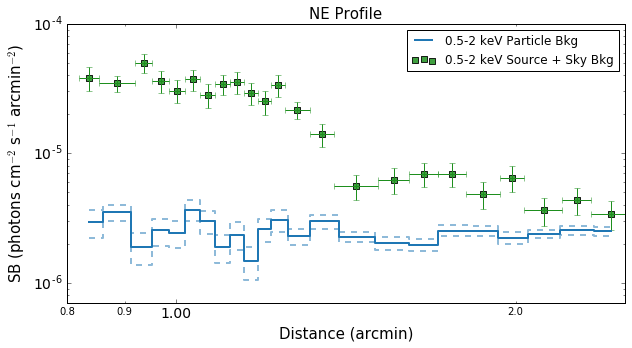

In [7]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(r, sx, c="#1e8f1e", alpha=0.85, s=35, marker="s",
           label="0.5-2 keV Source + Sky Bkg")
ax.errorbar(r, sx, xerr=r_err, yerr=sx_err, linestyle="None", color="#1e8f1e")
ax.step(r, bkg, where="mid", color="#1f77b4", linewidth=2,
        label="0.5-2 keV Particle Bkg")
ax.step(r, bkg - bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.step(r, bkg + bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.semilogx()
ax.semilogy()
ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(mtick.ScalarFormatter())
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xlim(rmin, rmax)
plt.ylim(7e-7, 1e-4)
plt.xlabel("Distance (arcmin)", size=15)
plt.ylabel(r"SB (photons cm$^{-2}$ s$^{-1}$ arcmin$^{-2}$)", size=15)
plt.legend(loc=1)
plt.title("NE Profile", size=15)
plt.show()

It can be seen that the discontinuity is indeed at r~1.5'. We fit the profile above with a broken power-law model with a constant sky background level of 5.45e-7 photons/s/cm^2/arcmin^2, as it was determined in the `PyXel Example - Constant Model` notebook.

In [12]:
model = IntModel(BrokenPow)(widths=r_err, ind1=0., ind2=1.2, norm=3.5e-5, rbreak=1.36, jump=2.5, const=5.45e-7)
model.const.fixed = True
fit = CstatFitter()
fitted_model = fit(model, r, raw_cts, bkg_cts, t_raw, t_bkg, maxiter=500)

52017


//anaconda/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  RuntimeWarning)
/Users/gogrean/code/pyxel/pyxel/optimizers.py:97: OptimizeWarning: Unknown solver options: eps, factr
  args=fargs, tol=acc, **kwargs)


The best-fitting parameters (ind1, ind2, norm, rbreak, jump) are:

In [14]:
print(fitted_model.parameters[:-1])

[ -2.88118926e-01   1.11924734e+00   3.69456390e-05   1.36504123e+00
   3.17788411e+00]


We use MCMC to calculate the uncertainties on the best-fitting parameters. This is lengthy, so we will load a pre-existing chain file. If you want to create the chain file yourself, set `clobber_chain=True`. The code will likely require a few hours to run.




FIT SUMMARY:

| Parameter   |      Value |   Lower Uncertainty |   Upper Uncertainty |
|-------------+------------+---------------------+---------------------|
| ind1        | -2.208e-01 |          -5.528e-01 |           5.315e-01 |
| ind2        |  1.116e+00 |          -2.030e-01 |           2.742e-01 |
| norm        |  3.585e-05 |          -7.935e-06 |           8.300e-06 |
| rbreak      |  1.366e+00 |          -1.455e-02 |           3.695e-02 |
| jump        |  3.178e+00 |          -6.765e-01 |           6.897e-01 |





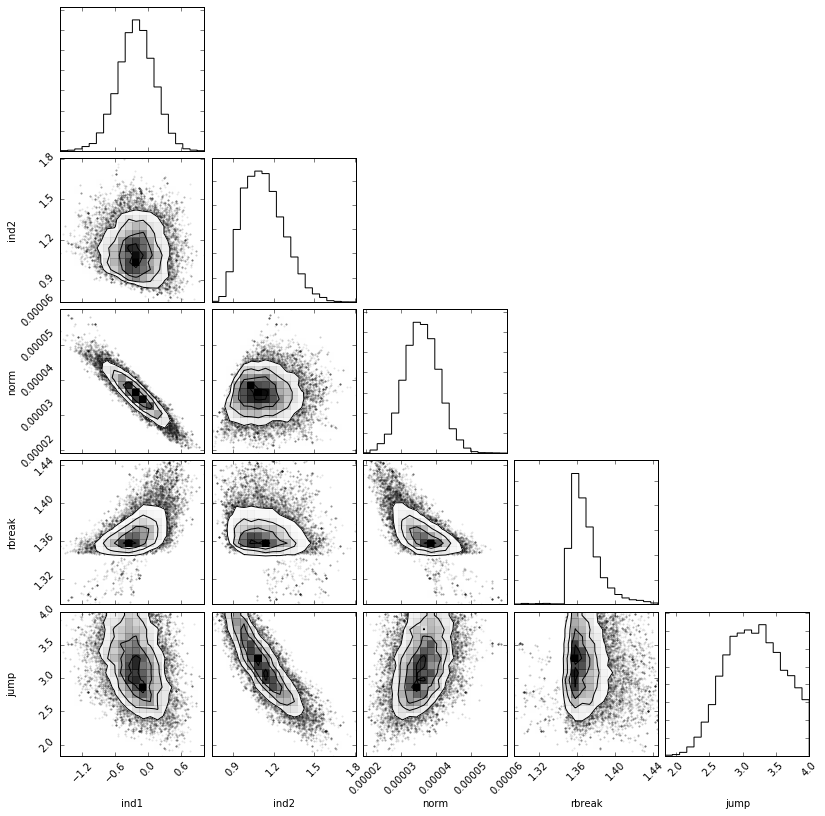

In [15]:
mcmc_model = BrokenPow(*fitted_model.parameters)
mcmc_model.const.fixed = True
mcmc_err = fit.mcmc_err(mcmc_model, r, raw_cts, bkg_cts, t_raw, t_bkg, 
                        cl=90., save_chain=True, clobber_chain=False, chain_filename=DATADIR+"ne_chain.dat",
                        clobber_corner=True, corner_filename=DATADIR+"ne_corner_plot.pdf")

Finally, we plot the data and the best-fitting model.

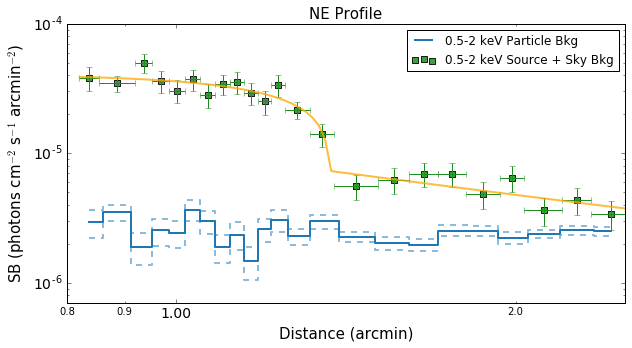

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(r, sx, c="#1e8f1e", alpha=0.85, s=35, marker="s",
           label="0.5-2 keV Source + Sky Bkg")
ax.errorbar(r, sx, xerr=r_err, yerr=sx_err, linestyle="None", color="#1e8f1e")
ax.step(r, bkg, where="mid", color="#1f77b4", linewidth=2,
        label="0.5-2 keV Particle Bkg")
ax.step(r, bkg - bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.step(r, bkg + bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.semilogx()
ax.semilogy()
ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(mtick.ScalarFormatter())
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xlim(rmin, rmax)
plt.ylim(7e-7, 1e-4)
plt.xlabel("Distance (arcmin)", size=15)
plt.ylabel(r"SB (photons cm$^{-2}$ s$^{-1}$ arcmin$^{-2}$)", size=15)
plt.legend(loc=1)
plt.title("NE Profile", size=15)

# Sample radii less sparsely, so that the broken power-law model doesn't look weird.
r_new = np.linspace(r[0] - r_err[0], r[-1] + r_err[-1], 100)
plt.plot(r_new, BrokenPow(*fitted_model.parameters)(r_new), color="#ffa500", linewidth=2, alpha=0.75)
plt.savefig(DATADIR + "zwcl2341-ne-bknpow.pdf", dpi=144)
plt.show()